In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from functions.model3 import GAN
import datetime
import json
from qiskit.circuit import ParameterVector
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path

In [3]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
#latest_model_path="models/models_2809.1230"

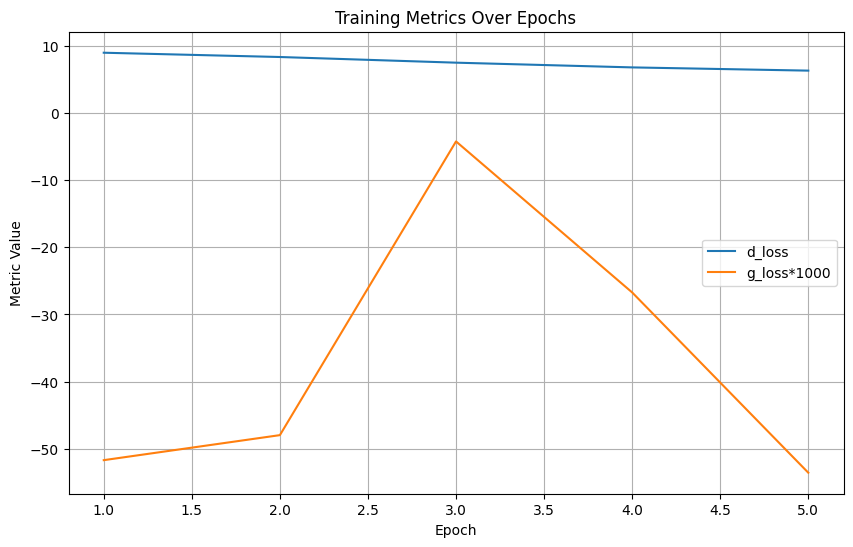

In [4]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1000)

In [5]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

In [6]:
feature_data, target_data = process_model_data(targets, features, tickers) #feature_data, target_data

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d

(1003, 32) (1003, 8)


2025-09-28 20:28:56.439384: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-09-28 20:28:56.439407: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-28 20:28:56.439448: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-28 20:28:56.439479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-28 20:28:56.439493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


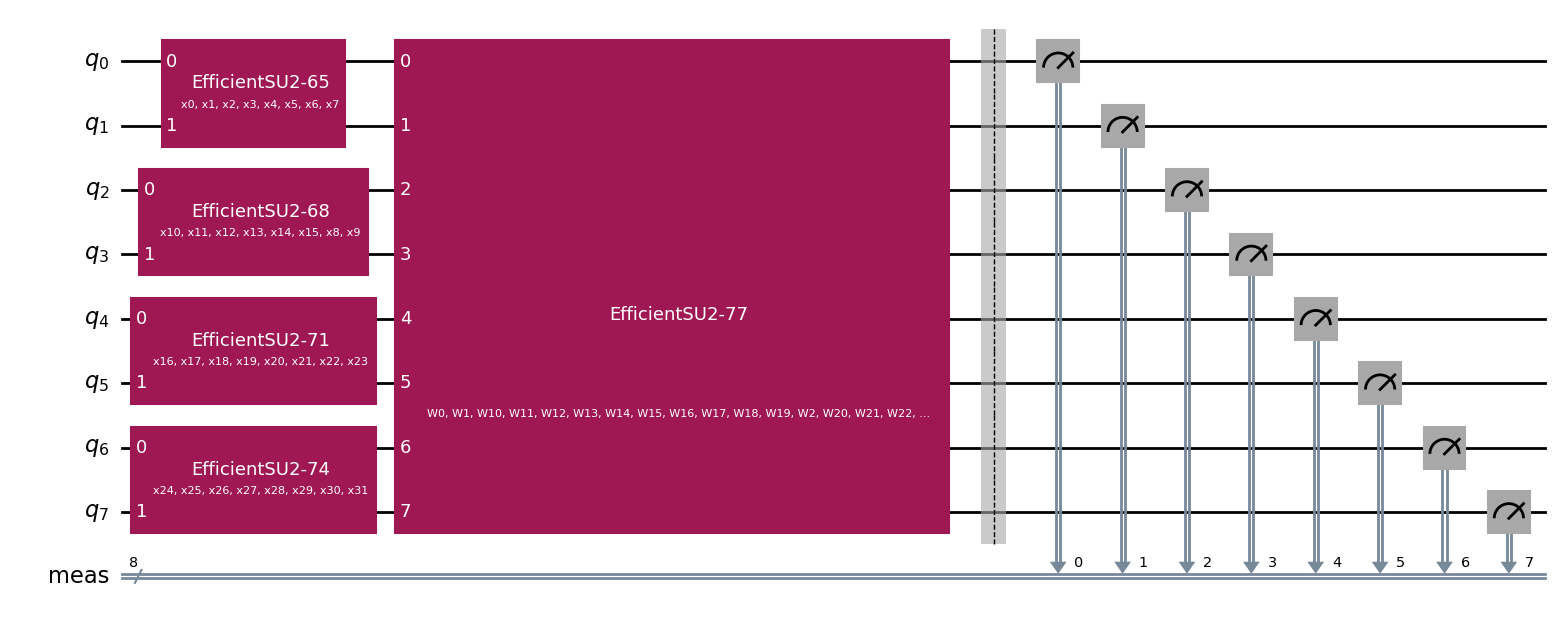

In [20]:
qc= two_qubit_circuit_tickers(tickers)
qc.draw('mpl')

In [ ]:
def infer_parameter_groups(circuit):
        """
        Basic heuristic: names starting with x/data -> data params,
        names starting with w/theta/th -> trainable params.
        """
        data_prefixes = ("x", "data")
        weight_prefixes = ("w", "theta", "th")
        data_params, weight_params, other = [], [], []

        for p in circuit.parameters:
            name = p.name.lower()
            if name.startswith(data_prefixes):
                data_params.append(p)
            elif name.startswith(weight_prefixes):
                weight_params.append(p)
            else:
                other.append(p)

        # If ambiguous, put leftovers into weight_params by default
        weight_params += other
        return data_params, weight_params

## Loading weights into the model

In [8]:
#latest_model_path="models/models_2809.1018"
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [ ]:
data_params, weight_params = infer_parameter_groups(qc)


In [9]:
param_vector = qc.parameters
param_list = list(param_vector)

In [ ]:
# mapping from Parameters to values
#weight_params=[param for param in param_list if param.name[:7]=="weights" ]
weight_param_dict = {param: val for param, val in zip(weight_params, loaded_weights)}

# Assign parameters to the circuit
qc_weighted = qc.assign_parameters(weight_param_dict)

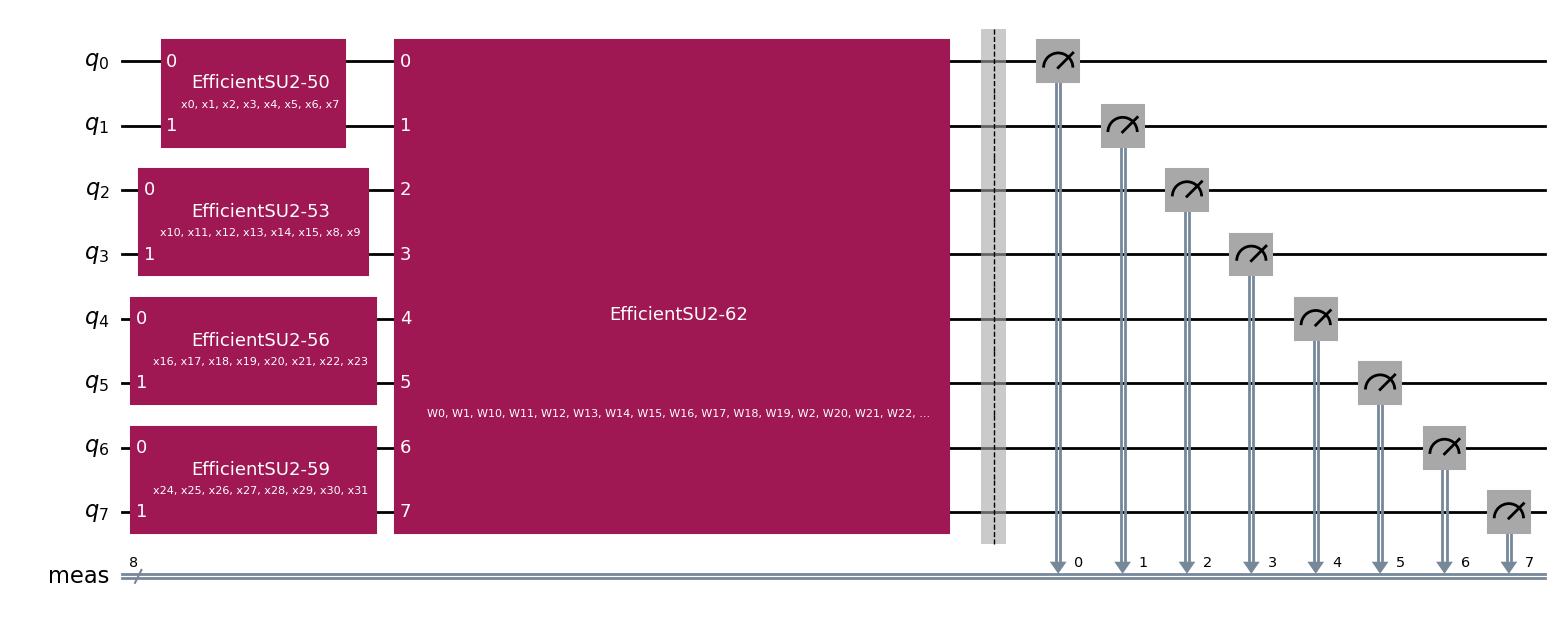

In [11]:
qc_weighted.draw('mpl')

### Encode data

In [ ]:
#load in example data
input_data = feature_data[0]

#data_params = list(qc_weighted.parameters)
data_param_dict = {param: val for param, val in zip(data_params, input_data)}

print (data_param_dict)
# Assign data encodings to the circuit
qc_data = qc_weighted.assign_parameters(data_param_dict)


ParameterView([Parameter(W0), Parameter(W1), Parameter(W10), Parameter(W11), Parameter(W12), Parameter(W13), Parameter(W14), Parameter(W15), Parameter(W16), Parameter(W17), Parameter(W18), Parameter(W19), Parameter(W2), Parameter(W20), Parameter(W21), Parameter(W22), Parameter(W23), Parameter(W24), Parameter(W25), Parameter(W26), Parameter(W27), Parameter(W28), Parameter(W29), Parameter(W3), Parameter(W30), Parameter(W31), Parameter(W4), Parameter(W5), Parameter(W6), Parameter(W7), Parameter(W8), Parameter(W9), Parameter(x0), Parameter(x1), Parameter(x10), Parameter(x11), Parameter(x12), Parameter(x13), Parameter(x14), Parameter(x15), Parameter(x16), Parameter(x17), Parameter(x18), Parameter(x19), Parameter(x2), Parameter(x20), Parameter(x21), Parameter(x22), Parameter(x23), Parameter(x24), Parameter(x25), Parameter(x26), Parameter(x27), Parameter(x28), Parameter(x29), Parameter(x3), Parameter(x30), Parameter(x31), Parameter(x4), Parameter(x5), Parameter(x6), Parameter(x7), Parameter(x

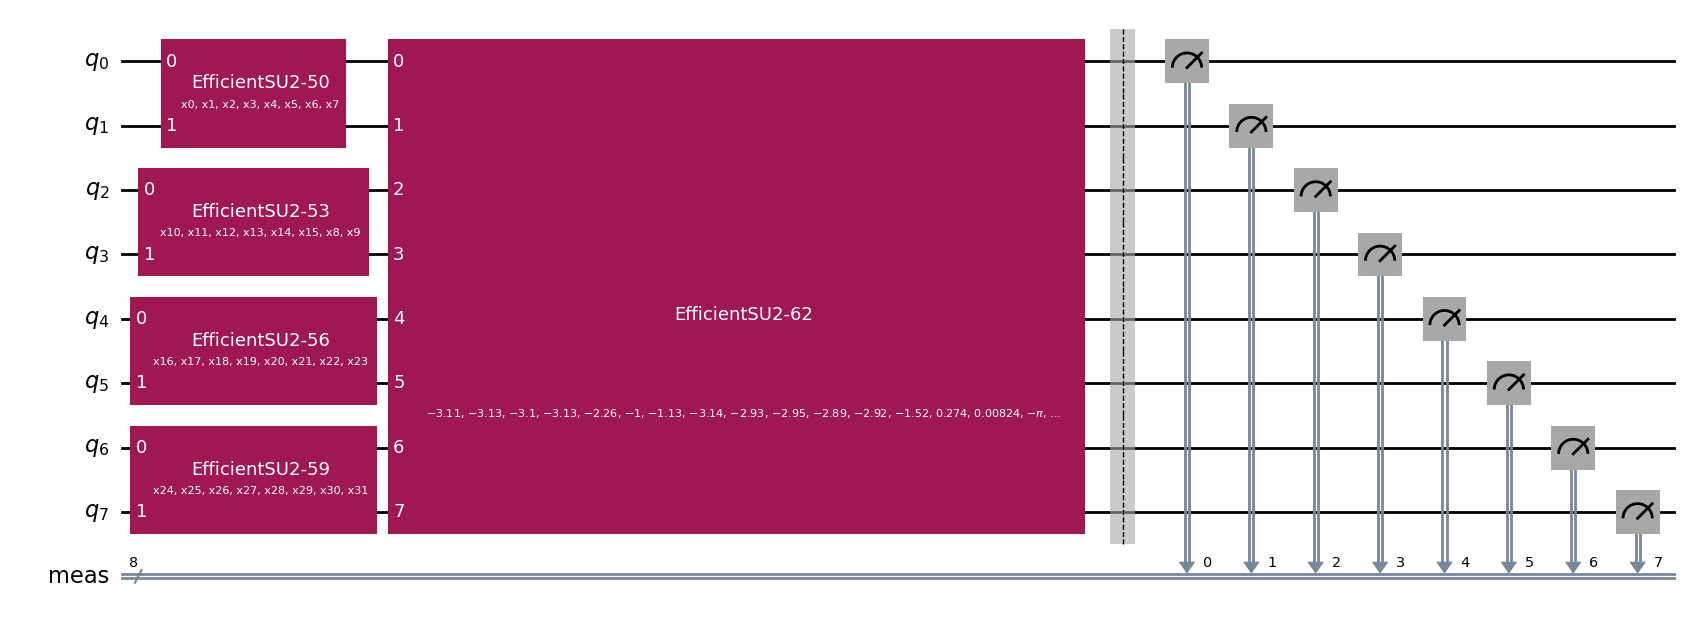

In [13]:
qc_data.draw('mpl')

### Run the circuit

In [14]:
from qiskit.quantum_info import SparsePauliOp
num_qubits = qc_data.num_qubits
observable = [SparsePauliOp.from_list([(f"{'I'*i}Z{'I'*(num_qubits-i-1)}", 1)]) for i in range(num_qubits)]

print(observable)

[SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIZIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIZ'],
              coeffs=[1.+0.j])]


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile

service = QiskitRuntimeService()
#backend = service.least_busy()
backend = GenericBackendV2(num_qubits=num_qubits)
qc_transpiled = transpile(qc_data, backend=backend, optimization_level=3)

estimator = EstimatorV2(mode=backend)

pub = (qc_transpiled, observable, data_param_dict) #primitive unified bloc program input for estimator
job = estimator.run([pub])
result = job.result()[0]
expectation_values = result.data.evs

management.get:WARNING:2025-09-28 20:31:21,883: Loading default saved account


KeyError: "no parameter named 'W0' is present"

In [ ]:
expectation_values

array([0.23583984, 0.89453125])

In [ ]:
target_data[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.05264116,  0.2914946 ], dtype=float32)>